### 1. Выберите датасет для классификации изображений

https://pytorch.org/vision/stable/datasets.html

Выбрал [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). Это изображения кошек и собак. 37 классов - разные породы кошек и собак. Может использоваться для сегментации. Здесь буду использовать для бинарной классификации - кошка или собака

In [ ]:
# импортируем библиотеки

import torch
import random
import numpy as np
import torchvision
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt


random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

<ipython-input-1-603600bba43f>:7: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


In [ ]:
!pip install dill
import dill

In [ ]:
normalizer = torchvision.transforms.Normalize(
    mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]
    )
# преобразование картинки в тензор и обратно
img2t = torchvision.transforms.ToTensor()
t2img = torchvision.transforms.ToPILImage()

In [ ]:
# resize картинок к 307x307
# kernel = 11 stride =4
# (307-11)/4 делится на цело
IMG_SIZE = 307
resizer = torchvision.transforms.Resize((IMG_SIZE,IMG_SIZE))

#сразу преобразуем к нужному размеру
transformer = torchvision.transforms.Compose(
                      [resizer,
                       torchvision.transforms.ToTensor(),
                       normalizer])

In [ ]:
# есть возможность при загрузке разделить картинки на обучающую выборку и тест
pet_train = torchvision.datasets.OxfordIIITPet(
    './', download=True, split='trainval',
    target_types='binary-category',transform=transformer
    )
pet_test = torchvision.datasets.OxfordIIITPet(
    './', download=True, split='test',
    target_types='binary-category',transform=transformer
    )

100%|██████████| 792M/792M [00:52<00:00, 15.0MB/s]


Extracting oxford-iiit-pet/images.tar.gz to oxford-iiit-pet


100%|██████████| 19.2M/19.2M [00:03<00:00, 6.08MB/s]


Extracting oxford-iiit-pet/annotations.tar.gz to oxford-iiit-pet


In [ ]:
#исходный датасет без трансформации
pet_test0 = torchvision.datasets.OxfordIIITPet(
    './', download=True, split='test',
    target_types='binary-category'
    )

In [ ]:
bin_classes = pet_train.bin_classes
# чтобы выравнять баланс по классам
# сгруппируем объекты по классам
cls_idx = {cls: [] for cls in bin_classes}

for i, obj in enumerate(pet_train):
    cls_lbl = bin_classes[obj[1]]
    cls_idx[cls_lbl].append(i)

(len(cls_idx['Cat']),len(cls_idx['Dog']))

(1188, 2492)

In [ ]:
# например возьмём в обучение собак столько же сколько кошек
balanced_idx = cls_idx['Cat'].copy()
balanced_idx.extend(random.sample(cls_idx['Dog'],len(cls_idx['Cat'])))
#сначалла идут кошки затем ровно столько же собак
len(balanced_idx),pet_train[balanced_idx[0]][1],pet_train[balanced_idx[-1]][1]

(2376, 0, 1)

In [ ]:
balanced_dataset = torch.utils.data.Subset(pet_train, balanced_idx)

### 2. Определите архитектуру нейросети и приведите ее описание (текстом или иным способом) в своей работе

архитектура alexNet

https://en.wikipedia.org/wiki/AlexNet#/media/File:AlexNet_Original_block_diagram.svg  
на картике видно две парраллельные ветки свёрток - это две GPU  
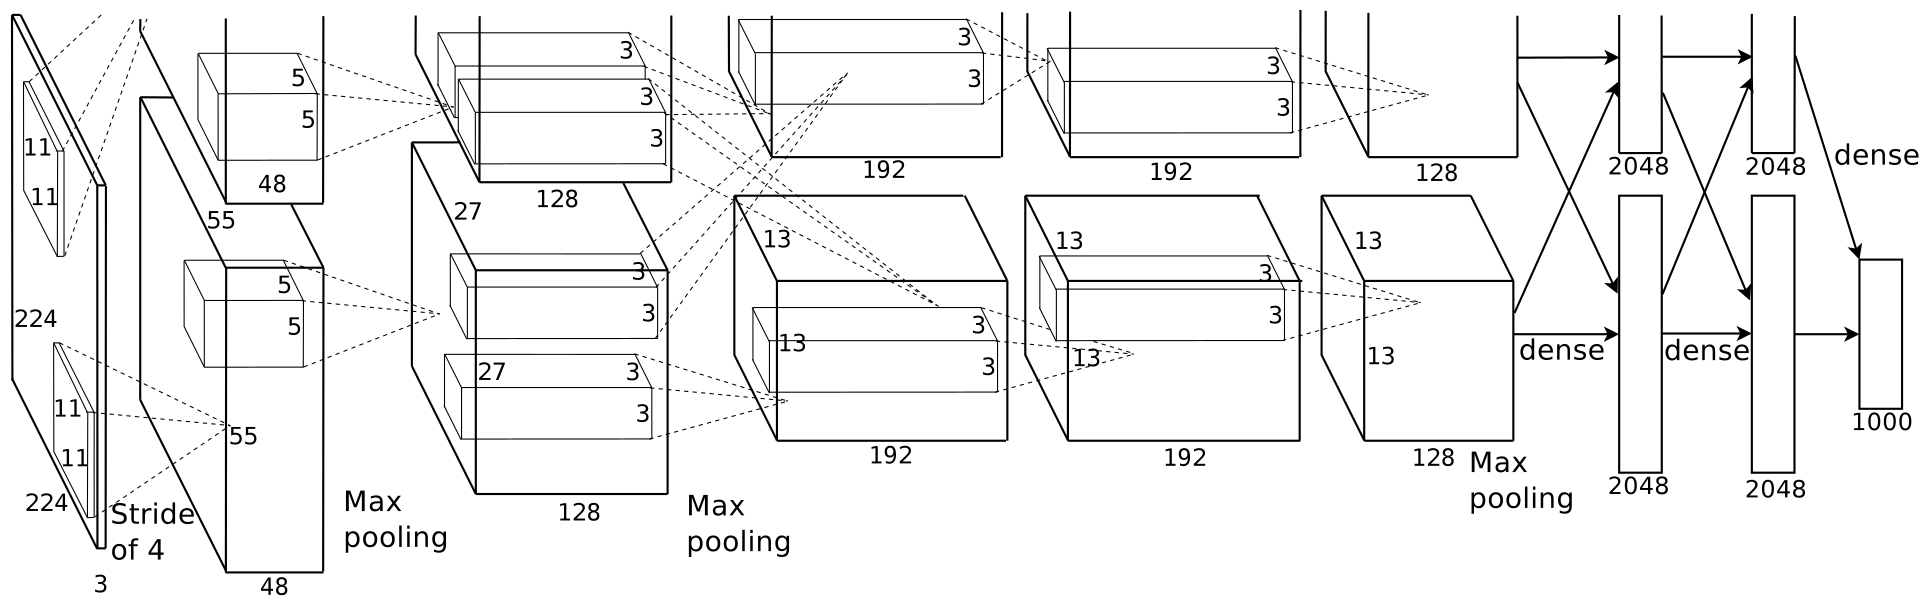
By Zhang, Aston and Lipton, Zachary C. and Li, Mu and Smola, Alexander J. - https://github.com/d2l-ai/d2l-en, CC BY-SA 4.0, https://commons.wikimedia.org/w/index.php?curid=152265711

In [ ]:
class AlexNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.features = torch.nn.Sequential(
            # (307 - 11) / 4 + 1
            # 307x307x3 -> 75x75x96
            torch.nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4),
            torch.nn.BatchNorm2d(96),
            torch.nn.ReLU(),
            # (75-3)/2+1
            # -> 37x37x96
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            # (37+2*2-5)/1+1 - здесь и дальше свёртки такие, что не меняют размер
            # -> 37x37x256
            torch.nn.Conv2d(96, 256, kernel_size=5, padding=2),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            # (37-3)/2+1
            # -> 18x18x256
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            # -> 18x18x384
            torch.nn.Conv2d(256, 384, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(384),
            torch.nn.ReLU(),
            # -> 18x18x384
            torch.nn.Conv2d(384, 384, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(384),
            torch.nn.ReLU(),
            # -> 18x18x256
            torch.nn.Conv2d(384, 256, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            # (18-3)/3+1
            # -> 6x6x256
            torch.nn.MaxPool2d(kernel_size=3),
        )
        self.classifier = torch.nn.Sequential(
            # 6x6x256 -> 9216
            torch.nn.Linear(9216, 500),
            torch.nn.ReLU(),
            torch.nn.Dropout(),
            torch.nn.Linear(500, 200),
            torch.nn.ReLU(),
            torch.nn.Dropout(),
            torch.nn.Linear(200, 2),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
anet = AlexNet()
anet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  

### 4. Обучите нейросеть

In [ ]:
# определяем, где будет обучаться наша СNN
# если есть граф процессор от Nvidia, то на нем. Если нет, то на cpu

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = "cpu"

# отправляем туда нашу нейронку
anet = anet.to(device)

In [ ]:
# в качестве функции потерь будем использовать CrossEntropyLoss()
loss = torch.nn.CrossEntropyLoss()

# в качестве оптимайзера, который будет вычислять градиенты и минимизировать функцию потерь, будем использовать Adam (Адаптивная оценка момента)
optimizer = torch.optim.Adam(anet.parameters(), lr=1.0e-3)

In [ ]:
len(pet_test)

3669

In [ ]:
BATCH_SIZE = 200
# загрузчик батча для обуающей выборки
dataloader = torch.utils.data.DataLoader(
    balanced_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    #прежде чем вернуть батч, его положат на устройство
    #? не понял как потом итерироваться по нему если он на куде
    #pin_memory=True,
    #pin_memory_device=device
)

# для тестовой выборки
testloader = torch.utils.data.DataLoader(pet_test, batch_size=BATCH_SIZE) #, drop_last=True)

In [ ]:
for obj in dataloader:
    print(obj[0].shape, obj[1])
    break

torch.Size([200, 3, 307, 307]) tensor([0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
        1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
        1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
        1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
        1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1,
        0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1])


In [ ]:
# чтобы посмотреть, как и что у нас тут менялось при оптимизации на тестовой выборке
test_accuracy_history = []
test_loss_history = []
train_loss_history = []

for epoch in range(100):

    train_loss_history.append(0)
    # если у dataloader drop_last=True, то total_sample != размеру выборки
    total_sample=0

    # на каждом шаге цикла получаем очередной батч из генератора
    for batch_images, batch_labels in dataloader:

        # обязательно обнуляем градиенты
        optimizer.zero_grad()

        X_batch = batch_images.to(device)
        y_batch = batch_labels.to(device)

        # делаем предсказание
        preds = anet.forward(X_batch)

        # считаем лосс значение
        loss_value = loss(preds, y_batch)

        #len(batch) - не все батчи одинаковые по длине, если выборка не кратна размеру батча
        train_loss_history[epoch] += loss_value.data.cpu() * len(batch_images)
        total_sample += len(batch_images)

        # берем градиенты
        loss_value.backward()

        # и пусть оптимайзер все оптимизирует
        optimizer.step()

    train_loss_history[epoch] /= total_sample


    # бежим по батчам теста и собираем потери и точность на тесте
    test_loss = 0
    test_accuracy = 0
    total_sample=0

    #for i,(batch_images, batch_labels) in enumerate(testloader):
    for batch_images, batch_labels in testloader:
        X_batch = batch_images.to(device)
        y_batch = batch_labels.to(device)

        preds = anet.forward(X_batch)
        #print(i,'preds:', preds, i,'y_batch:', y_batch)
        loss_value = loss(preds, y_batch)

        test_loss += loss_value.data.cpu() * len(batch_images)
        test_accuracy += (preds.argmax(dim=1) == y_batch).float().sum().data.cpu()
        total_sample += len(batch_images)

    test_loss_history.append(test_loss / total_sample)
    test_accuracy_history.append(test_accuracy / total_sample)

    print(f"epoch{epoch} - accuracy test {test_accuracy_history[epoch]} ")

epoch0 - accuracy test 0.48323795199394226 
epoch1 - accuracy test 0.5113109946250916 
epoch2 - accuracy test 0.5388389229774475 
epoch3 - accuracy test 0.5521940588951111 
epoch4 - accuracy test 0.5838103294372559 
epoch5 - accuracy test 0.6047969460487366 
epoch6 - accuracy test 0.6099754571914673 
epoch7 - accuracy test 0.6192423105239868 
epoch8 - accuracy test 0.6334151029586792 
epoch9 - accuracy test 0.6257835626602173 
epoch10 - accuracy test 0.653311550617218 
epoch11 - accuracy test 0.610520601272583 
epoch12 - accuracy test 0.680839478969574 
epoch13 - accuracy test 0.6554919481277466 
epoch14 - accuracy test 0.7048242092132568 
epoch15 - accuracy test 0.6950122714042664 
epoch16 - accuracy test 0.7138184905052185 
epoch17 - accuracy test 0.6830198764801025 
epoch18 - accuracy test 0.6892886161804199 
epoch19 - accuracy test 0.6884709596633911 
epoch20 - accuracy test 0.7274461984634399 
epoch21 - accuracy test 0.7219951152801514 
epoch22 - accuracy test 0.6647588014602661 


### 5. Постройте на одном графике кривые изменения функции потерь на тесте и обучении


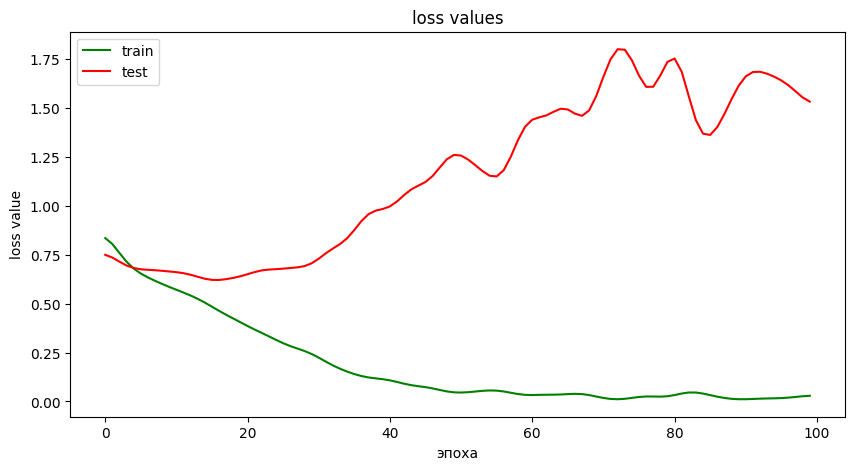

In [ ]:

# строим графики - функции потерь

fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111)
ax.set(title = 'loss values',
       xlabel = 'эпоха',
       ylabel = 'loss value')
train_loss_smoothed = gaussian_filter1d(train_loss_history, sigma=2)
ax.plot(train_loss_smoothed, color='green',  label='train')

test_loss_smoothed = gaussian_filter1d(test_loss_history, sigma=2)
ax.plot(test_loss_smoothed, color='red',  label='test')
ax.legend()
plt.show()



### 6. Постройте график изменения выбранной метрики качества на тесте


<ipython-input-37-61e40d118354>:3: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


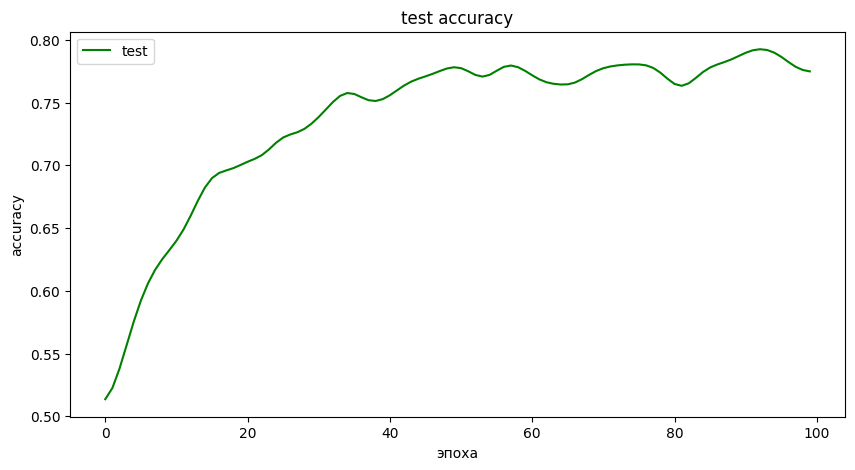

In [ ]:
# График изменения accuracy на тестовых данных

fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111)
ax.set(title = 'test accuracy',
       xlabel = 'эпоха',
       ylabel = 'accuracy')
test_accuracy_smoothed = gaussian_filter1d(test_accuracy_history, sigma=2)
ax.plot(test_accuracy_smoothed, color='green',  label='test')

ax.legend()
plt.show()


### 7. Сохраните в файл одно изображение из тестовой выборки


In [ ]:
# сохраняем произвольный объект из датасета (тензор) в файл
idx = np.random.randint(0,len(pet_test))
timg = pet_test[idx][0]
torch.save(timg,'rnd_tensor.pt')
timg.shape

torch.Size([3, 307, 307])

In [ ]:
# сохраняем исходную картинку
img = pet_test0[idx][0]
print(idx)

img.save('rnd_img.jpg')

2732


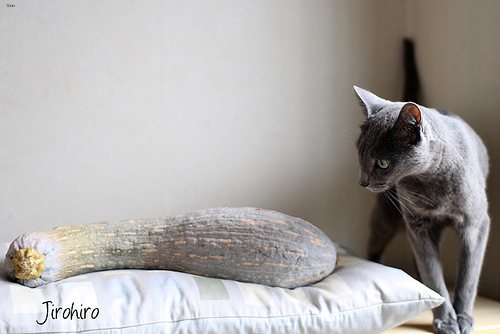

In [ ]:
img

### 8. Сохраните обученную нейросеть в файл


In [ ]:
with open("model.dill", "wb") as dill_file:
    dill.dump(anet, dill_file)

### 9. Загрузите изображение из файла


In [ ]:
test_data = torch.load('rnd_tensor.pt')
test_data.shape

<ipython-input-12-d19d134e8fb8>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load('rnd_tensor.pt')


torch.Size([3, 307, 307])

### 10. Загрузите нейросеть


In [ ]:
ifile = open("model.dill", "rb")
modelp = dill.load(ifile)
ifile.close()

print(modelp)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  

### 11. Выполните предсказание с помощью загруженной из файла нейросети и оцените его правильность

In [ ]:
# переводим входной тензор-изображение в тензор нужного нам размера
t_data = torch.tensor([test_data.numpy()])

<ipython-input-15-94f1da74720b>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  t_data = torch.tensor([test_data.numpy()])


In [ ]:
# проверяем
t_data.shape

torch.Size([1, 3, 307, 307])

In [ ]:
# проверяем, на чем можем считать
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# отправляем туда модель
modelp.to(dev)
model_data = modelp.to(dev)

# тензор-изображение тоже
t_data = t_data.to(dev)

In [ ]:
# делаем предсказание
preds = modelp.forward(t_data)

In [ ]:
print(preds)

tensor([[ 5.6476, -6.9514]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [ ]:
# выбираем максимальную вероятность, как результат предсказания.
# Не забывая отправить на cpu
prediction = np.argmax(preds.to('cpu').detach().numpy(),axis=1)

In [ ]:
# смотрим, что предсказалось
print(prediction)

[0]


класс 0 - это кот